# Line Characterization

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import skew
from model import main, read_data, doppler_shift, plot_spectra

% matplotlib inline

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=30)

### Functions

In [3]:
def get_stats(data):
    y = data['x_frec']
    return np.mean(y), np.std(y), skew(y)

def plot_stat(vout, logtau, x_scatter, y_scatter, x_plot, y_plot, stat='mn'):
    
    ylabel = 'Mean'
    if stat == 'std':
        ylabel = 'Standard Deviation'
    elif stat == 'skw':
        ylabel = 'Skewness'
        
    vout_lab = r'$v_{\mathrm{out}}=$ ' + '${0:.0f}$'.format(vout) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'
    tau_lab = r'$\tau_{\mathrm{H}}=$ ' + '$10^{0:.0f}$'.format(logtau)
    lab = vout_lab + '$\;\;\;$' + tau_lab
    xlabel = r'$v_{\mathrm{rot}}$  ($\mathrm{km}$ $\mathrm{s^{-1}}$)'
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(x_plot, y_plot, label='DS', linewidth=2, alpha=0.5, color='black')
    plt.scatter(x_scatter, y_scatter, label='RT', marker='^', color='black')
    plt.title(lab)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ymin = np.min([np.min(y_scatter), np.min(y_plot)])
    ymax = np.max([np.max(y_scatter), np.max(y_plot)])
    #deltay = (ymin+ymax)/20
    #plt.ylim(ymin-deltay, ymax+deltay)
    plt.xticks([0,50,100])
    plt.yticks(np.linspace(ymin, ymax, 3))
    plt.legend(loc='best')
    plt.savefig('./results/line_characterization_'+stat+'_vout'+str(vout)+'_logtau'+str(logtau)+'.png', 
                format='png', transparent=False, bbox_inches='tight')
    plt.close()

### Figures: mean_line, standard_deviation, skewness

In [4]:
vrots = [0,50,100]
vrots_doppler = np.linspace(0, 110, 15)
vouts = [5,25,50]
logtaus = [5, 6, 7]

for logtau in logtaus:
    for vout in vouts:
        
        x_rt, x_d = [], []

        y_mn_rt, y_mn_d = [], []
        y_std_rt, y_std_d = [], []
        y_skw_rt, y_skw_d = [], []
        
        for vrot in vrots:
            data_rt = read_data(vrot=vrot, vout=vout, logtau=logtau)
            mn, std, skw = get_stats(data_rt)

            x_rt.append(vrot)
            y_mn_rt.append(mn)
            y_std_rt.append(std)
            y_skw_rt.append(skw)
        
        for vrot_d in vrots_doppler:
            data = read_data(vrot=0, vout=vout, logtau=logtau)
            data_doppler = doppler_shift(data, vrot_d)
            mn, std, skw = get_stats(data_doppler)
            
            x_d.append(vrot_d)
            y_mn_d.append(mn)
            y_std_d.append(std)
            y_skw_d.append(skw)
        
        plot_stat(vout, logtau, x_rt, y_mn_rt, x_d, y_mn_d, stat='mn')
        plot_stat(vout, logtau, x_rt, y_std_rt, x_d, y_std_d, stat='std')
        plot_stat(vout, logtau, x_rt, y_skw_rt, x_d, y_skw_d, stat='skw') 

### Functions

In [5]:
def get_valley_intensity(y):
    
    valley_intensity = y[0]
    
    for i in range(1, len(y)-1):
        past = y[i-1]
        current = y[i]
        future = y[i+1]
        
        if (past>=current and current<=future and current>=valley_intensity):
            valley_intensity = current
    
    return valley_intensity

def plot_valley(vrot, vout, logtau, x_plot, y_plot):        
        
    vrot_lab = r'$v_{\mathrm{rot}}=$ ' + '${0:.0f}$'.format(vrot) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'    
    vout_lab = r'$v_{\mathrm{out}}=$ ' + '${0:.0f}$'.format(vout) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'
    lab = vrot_lab + '$\;\;\;$' + vout_lab
    tau_lab = r'$\tau_{\mathrm{H}}=$ ' + '$10^{0:.0f}$'.format(logtau)
    xlabel = r'$\theta$ ($\mathrm{radians}$)'
    ylabel = 'Valley Intensity'
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(x_plot, y_plot, label=tau_lab, linewidth=2, alpha=1.0, color='black')
    plt.title(lab)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ymin = np.min(y_plot)
    ymax = np.max(y_plot)
    #plt.xticks([0,50,100])
    plt.yticks(np.linspace(ymin, ymax, 3))
    plt.legend(loc='best')
    plt.savefig('./results/line_characterization_vi_vout'+str(vout)+'_vrot'+str(vrot)+'_logtau'+str(logtau)+'.png', 
                format='png', transparent=False, bbox_inches='tight')
    plt.close()

### Figures: valley_intensity

In [6]:
vrot = 50
vout = 75
num_thetas = 9
cos_thetas = np.linspace(1, 0, num_thetas) 
thetas = np.arccos(cos_thetas)

for logtau in logtaus:
    
    x_d = []
    y_vi_d = []

    for i in range(len(thetas)-1):
        min_theta = thetas[i]
        max_theta = thetas[i+1]
        
        x, y = main(vrot, vout, logtau, min_theta, max_theta)

        x_d.append(min_theta)
        y_vi_d.append(get_valley_intensity(y))

    plot_valley(vrot, vout, logtau, x_d, y_vi_d)

### Example

In [7]:
vrot = 100
vout = 5
logtau = 5
min_theta = np.pi/2.0 - 0.15
max_theta = np.pi/2.0

x, y = main(vrot, vout, logtau, min_theta, max_theta)

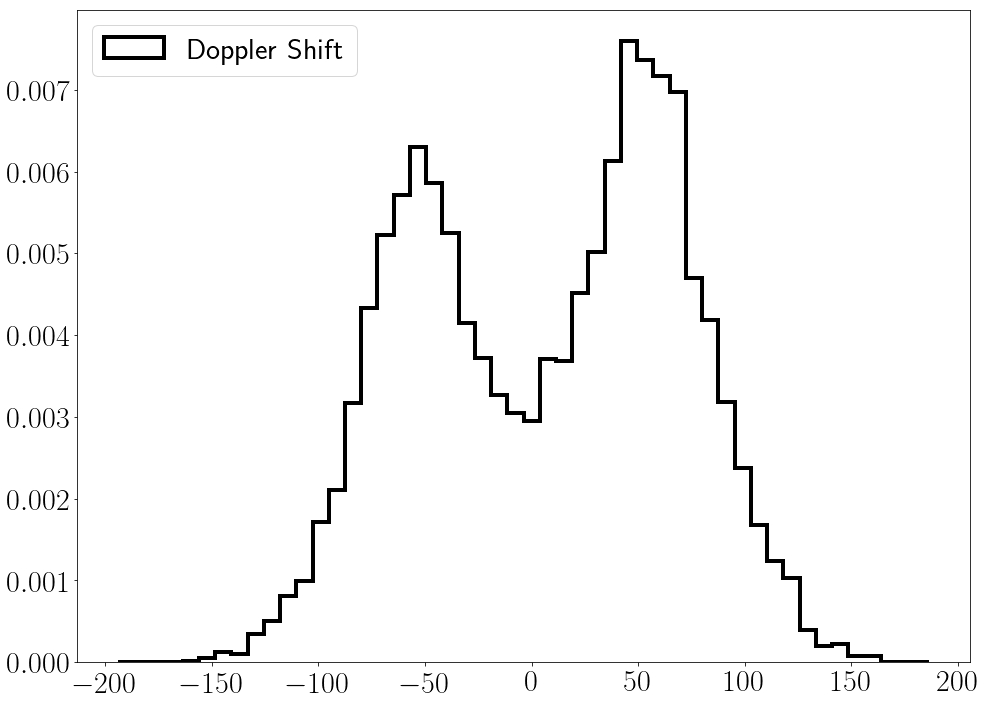

In [8]:
fig, ax = plt.subplots(figsize=(16,12))
plot_spectra(x, y, ax, lw=4, label='Doppler Shift')
plt.legend(loc='upper left')
plt.show()

In [9]:
np.mean(y), np.std(y), skew(y)

(0.02, 0.018592213281752125, 0.46381070958573417)

In [10]:
get_valley_intensity(y)

0.028094001730910059